<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import time
import scipy as sp
import pickle
import musical

Matplotlib created a temporary cache directory at /tmp/matplotlib-klrdn7ac because the default path (/gpfs/home/yb2612/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Overview 

In this notebook, we demonstrate how to refit an input matrix $X$ against a signature catalog. Refitting can be performed as a standalone task for predicting signature exposures, or as a downstream step after *de novo* signature discovery and matching the *de novo* signatures to the catalog. 

# Input data

The input data for refitting is the mutation count matrix $X$ and the signature catalog $W$. 

## The mutation count matrix

Here we use a simulated dataset based on PCAWG skin melanomas to demonstrate how to perform refitting. The dataset contains 15 SBS signatures. 

Below, `X` is the simulated mutation count matrix. `W_true` is the true signatures present in the dataset (i.e., the 15 SBS signatures). `H_true` is the true exposure matrix from which `X` is simulated. 

In reality, only `X` is needed, since `W_true` and `H_true` are unknown. We read the truth information here so that we can evaluate the refitting results.

In [43]:
cesc_X = pd.read_csv('/gpfs/data/courses/aio2025/yb2612/data/musical/cesc_X_converted.csv', index_col=0)
ucec_X = pd.read_csv('/gpfs/data/courses/aio2025/yb2612/data/musical/ucec_X_converted.csv', index_col=0)
ov_X = pd.read_csv('/gpfs/data/courses/aio2025/yb2612/data/musical/ov_X_converted.csv', index_col=0)
brca_X = pd.read_csv('/gpfs/data/courses/aio2025/yb2612/data/musical/brca_X_converted.csv', index_col=0)
cesc_X

,TCGA-DG-A2KK,TCGA-C5-A1ML,TCGA-FU-A3TX,TCGA-EK-A2RD,TCGA-EK-A2PM,TCGA-C5-A3HL,TCGA-VS-A8QF,TCGA-VS-A94X,TCGA-C5-A1BF,TCGA-DS-A1OB,...,TCGA-EA-A1QT,TCGA-VS-A958,TCGA-VS-A9U6,TCGA-EA-A3HU,TCGA-EK-A2RE,TCGA-VS-A954,TCGA-VS-A9UI,TCGA-FU-A5XV,TCGA-EA-A3QD,TCGA-VS-A952
A[C>A]A,152,88,96,145,153,190,180,174,142,155,...,35,99,170,118,54,157,392,87,68,112
A[C>A]C,90,57,55,116,79,99,120,174,100,93,...,22,33,80,66,39,57,165,53,64,75
A[C>A]G,49,28,20,31,43,43,58,61,50,47,...,12,19,47,31,21,36,58,21,20,29
A[C>A]T,96,39,35,62,85,65,92,789,83,83,...,25,32,88,95,29,70,273,43,34,69
C[C>A]A,126,70,60,107,124,86,138,249,132,139,...,49,49,126,75,34,223,243,55,33,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,60,31,23,208,31,250,65,205,38,49,...,29,60,25,91,64,33,156,143,34,14
T[T>G]A,36,19,11,9,17,21,67,673,30,39,...,4,7,18,63,18,12,200,9,10,20
T[T>G]C,48,41,7,12,25,17,65,478,44,63,...,18,21,20,40,21,18,133,11,13,13
T[T>G]G,50,37,14,22,30,28,56,183,59,85,...,15,10,29,63,17,17,126,20,15,15


## The signature catalog 

MuSiCal provides several signature catalogs.

Let's first load the default SBS catalog, which is `COSMIC-MuSiCal_v3p2_SBS_WGS`. This catalog includes 77 COSMIC v3.2 SBS signatures, 6 SBS signatures additionally discovered by MuSiCal from PCAWG samples, and a revised spectrum of SBS40 based on MuSiCal. Below, `catalog` is a catalog class object. Signatures in the catalog can be accessed through `catalog.W`. We see that there are in total 84 signatures. 

Other catalogs can be loaded if a name is specified. For example, the following line loads the preferred indel signature catalog. 
```
catalog = musical.load_catalog('MuSiCal_v4_Indel_WGS')
```

Directly refitting our dataset `X` against all 96 signatures in the catalog will introduce many false positives, leading to over-assignment. It is thus better to restrict our catalog to only those signatures found in the specific tumor type. 

You can select your own preferred set of signatures. But MuSiCal provides such information based on our PCAWG reanalysis. 

Choosing catalog and tumor type:
* Breast invasive carcinoma (BRCA) - 'Breast.AdenoCA', 'Breast.DCIS', 'Breast.LobularCA'
* Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC) - 'Cervix.AdenoCA', 'Cervix.SCC'
* Ovarian serous cystadenocarcinoma (OV) - 'Ovary.AdenoCA'
* Uterine corpus endometrial carcinoma (UCEC) - 'Uterus.AdenoCA'

In [44]:
print("Catalogs:", musical.catalog.CATALOG_NAMES)

# choose catalog
W_catalog = musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS')
print("\nSignatures in catalog:", W_catalog.W.shape[1])

print("\nTumor types in chosen catalog:", catalog.show_tumor_type_options().tolist())

# choose restrict
W_catalog.restrict_catalog(tumor_type='Breast.LobularCA')
print("\nSignatures after restriction:", W_catalog.W.shape[1])

Catalogs: ['COSMIC_v2_SBS_WGS', 'COSMIC_v3_SBS_WGS', 'COSMIC_v3_SBS_WES', 'COSMIC_v3p1_SBS_WGS', 'COSMIC_v3p2_SBS_WGS', 'COSMIC-MuSiCal_v3p2_SBS_WGS', 'COSMIC_v3p1_Indel', 'MuSiCal_v4_Indel_WGS']

Signatures in catalog: 84

Tumor types in chosen catalog: ['Biliary.AdenoCA', 'Bladder.TCC', 'Bone.Benign', 'Bone.Epith', 'Bone.Osteosarc', 'Breast.AdenoCA', 'Breast.DCIS', 'Breast.LobularCA', 'CNS.GBM', 'CNS.Medullo', 'CNS.Oligo', 'CNS.PiloAstro', 'Cervix.AdenoCA', 'Cervix.SCC', 'ColoRect.AdenoCA', 'Eso.AdenoCA', 'Head.SCC', 'Kidney.ChRCC', 'Kidney.RCC', 'Liver.HCC', 'Lung.AdenoCA', 'Lung.SCC', 'Lymph.BNHL', 'Lymph.CLL', 'Myeloid.AML', 'Myeloid.MDS', 'Myeloid.MPN', 'Ovary.AdenoCA', 'Panc.AdenoCA', 'Panc.Endocrine', 'Prost.AdenoCA', 'Skin.Melanoma', 'SoftTissue.Leiomyo', 'SoftTissue.Liposarc', 'Stomach.AdenoCA', 'Thy.AdenoCA', 'Uterus.AdenoCA']

Signatures after restriction: 23


In [7]:
cesc_ad_cat = musical.load_catalog()
cesc_ad_cat.restrict_catalog(tumor_type='Cervix.AdenoCA')
cesc_ad_W = cesc_ad_cat.W
print(cesc_ad_W.shape[1])

cesc_scc_cat = musical.load_catalog()
cesc_scc_cat.restrict_catalog(tumor_type='Cervix.SCC')
cesc_scc_W = cesc_scc_cat.W
print(cesc_scc_W.shape[1])

19
20


In [8]:
ucec_cat = musical.load_catalog()
ucec_cat.restrict_catalog(tumor_type='Uterus.AdenoCA')
ucec_cat_W = ucec_cat.W
print(ucec_cat_W.shape[1])

26


In [9]:
ov_cat = musical.load_catalog()
ov_cat.restrict_catalog(tumor_type='Ovary.AdenoCA')
ov_cat_W = ov_cat.W
print(ov_cat_W.shape[1])

27


In [12]:
brca_ad_cat = musical.load_catalog()
brca_ad_cat.restrict_catalog(tumor_type='Breast.AdenoCA')
brca_ad_cat_W = brca_ad_cat.W
print(brca_ad_cat_W.shape[1])

brca_dcis_cat = musical.load_catalog()
brca_dcis_cat.restrict_catalog(tumor_type='Breast.DCIS')
brca_dcis_cat_W = brca_dcis_cat.W
print(brca_dcis_cat_W.shape[1])

brca_lob_cat = musical.load_catalog()
brca_lob_cat.restrict_catalog(tumor_type='Breast.LobularCA')
brca_lob_cat_W = brca_lob_cat.W
print(brca_lob_cat_W.shape[1])

28
22
23


We can further restrict our catalog by removing signatures associated with mismatch repair deficiency (MMRD) or polymerase proofreading deficiency (PPD) (e.g., samples with POLE-exo mutations), since we know that this simulated dataset does not contain MMRD or PPD samples. 

If you are not sure whether your dataset contains MMRD/PPD samples, you can first perform a refitting including the MMRD/PPD signatures, and then use the `musical.preprocessing` module to determine if there is a cluster of MMRD/PPD samples within your dataset. If so, you can separate these samples and perform refitting again for the two clusters of samples separately. Of course other methods can be used to determine MMRD/PPD samples, e.g., by looking for hypermutations, inspecting POLE-exo mutations, detecting microsatellite instabilities, etc. 

In this case, no additional signatures are removed, since none of the 15 skin melanoma-specific signatures are associated with MMRD or PPD. 

We can finally obtain signatures in the catalog. 

In [13]:
cesc_ad_W

,SBS1,SBS2,SBS5,SBS10a,SBS10b,SBS10c,SBS10d,SBS13,SBS14,SBS15,SBS20,SBS21,SBS26,SBS28,SBS54,SBS95,SBS96,SBS98,SBS97
Type,,,,,,,,,,,,,,,,,,,
A[C>A]A,8.861572e-04,5.800168e-07,0.011998,2.190170e-03,0.000182,0.004331,0.010114,1.819920e-03,0.001120,0.000944,6.192834e-04,1.569926e-04,0.000873,0.000784,0.002160,0.014191,0.002303,0.013372,3.393376e-04
A[C>A]C,2.280405e-03,1.480043e-04,0.009438,1.770137e-03,0.006540,0.014830,0.018446,7.209682e-04,0.013106,0.000497,1.390636e-03,2.359889e-03,0.000528,0.002530,0.000796,0.004125,0.000252,0.010144,4.083738e-03
A[C>A]G,1.770314e-04,5.230151e-05,0.001850,1.500116e-04,0.000053,0.000657,0.000727,2.639884e-04,0.000413,0.000046,2.180998e-05,2.939862e-04,0.000114,0.000353,0.001640,0.001476,0.000000,0.002156,4.285896e-04
A[C>A]T,1.280227e-03,9.780282e-05,0.006609,1.700132e-02,0.000016,0.013128,0.014197,3.479847e-04,0.082636,0.001110,1.240568e-03,6.209709e-04,0.000619,0.003970,0.000414,0.001789,0.000000,0.012239,1.545020e-03
C[C>A]A,3.120554e-04,2.080060e-04,0.007429,3.180247e-03,0.000521,0.017433,0.010004,1.399938e-03,0.016307,0.041809,3.761721e-02,2.219896e-16,0.001410,0.002030,0.000063,0.002319,0.000000,0.007782,3.545584e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G[T>G]T,1.460259e-05,2.230064e-16,0.002350,2.210172e-03,0.005160,0.007474,0.000948,2.889873e-06,0.002251,0.001390,3.561630e-03,2.589878e-03,0.006051,0.020598,0.000012,0.003204,0.004054,0.004398,1.199683e-07
T[T>G]A,2.230396e-16,1.670048e-05,0.005219,2.690209e-03,0.011300,0.008731,0.019898,1.839919e-04,0.000099,0.000231,2.221016e-16,4.649782e-04,0.001430,0.042295,0.000032,0.001073,0.003347,0.008400,2.296746e-04
T[T>G]C,5.510978e-05,7.040203e-05,0.006559,2.230173e-16,0.005550,0.000952,0.000738,2.219902e-16,0.001201,0.000294,2.221016e-16,3.789822e-04,0.001720,0.035696,0.000706,0.002069,0.001813,0.005467,3.090285e-04


# Refitting 

Refitting can be performed with `musical.refit.refit()`.

## Naive NNLS 

Let's first try naive NNLS. This can be achieved by setting `method` to `thresh_naive` and `thresh` to `0`. The method `thresh_naive` simply performs NNLS, and then set signatures with relative exposures smaller than `thresh` to have zero exposures.  

In [58]:
cesc_ad_H_naive, cesc_ad_model_naive = musical.refit.refit(cesc_X, cesc_ad_W, method='thresh_naive', thresh=0)
cesc_ad_H_naive

,TCGA-DG-A2KK,TCGA-C5-A1ML,TCGA-FU-A3TX,TCGA-EK-A2RD,TCGA-EK-A2PM,TCGA-C5-A3HL,TCGA-VS-A8QF,TCGA-VS-A94X,TCGA-C5-A1BF,TCGA-DS-A1OB,...,TCGA-EA-A1QT,TCGA-VS-A958,TCGA-VS-A9U6,TCGA-EA-A3HU,TCGA-EK-A2RE,TCGA-VS-A954,TCGA-VS-A9UI,TCGA-FU-A5XV,TCGA-EA-A3QD,TCGA-VS-A952
SBS1,429.822231,627.340787,207.917350,134.272515,481.139034,361.275017,1833.649602,1661.548400,686.536940,857.548075,...,107.051253,217.745603,212.063248,155.189354,175.249830,132.017337,31.320337,285.023834,159.566656,179.013880
SBS2,23.729853,6.549181,50.285625,21.083174,0.000000,45.955373,699.220185,0.000000,42.678183,5.874639,...,9.826927,24.994541,0.000000,73.557015,62.824495,55.224116,207.539256,17.333190,1.297587,0.000000
SBS5,5304.254588,4214.573524,1695.539360,2194.181674,2964.718896,3736.981661,10669.631644,1321.516307,5421.761913,7599.824212,...,1327.174335,2076.434145,2258.173229,3202.113140,2181.336510,2149.140710,5602.715017,2640.498046,1697.474528,2286.557802
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24243.695437,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,129.799476,0.000000,0.000000,23.544362,0.000000,0.000000,209.774690,14295.478607,138.337888,73.094472,...,0.000000,0.000000,0.000000,9.195442,0.038104,15.215311,0.000000,0.000000,0.000000,19.627957
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,46.602970,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,34.303849,7.070979,62.754165,17.145404,134.702359,70.624007,0.000000,0.000000,22.055322,89.002204,...,38.709545,28.463938,112.443366,83.805441,0.000000,288.944767,448.663131,32.906325,8.469096,90.569848
SBS13,117.681919,69.453262,85.649169,0.000000,22.450318,57.277108,517.860948,11.813977,161.290501,131.028489,...,16.561518,25.231684,39.850946,67.903892,50.664530,63.392442,288.055181,0.000000,8.448401,54.423022
SBS14,137.042476,0.000000,103.133070,95.022289,179.358061,57.175763,0.000000,1935.789893,87.371673,0.000000,...,18.849196,37.475576,323.096481,172.939751,0.000000,72.350853,669.638287,0.000000,86.168001,214.625100
SBS15,0.000000,34.305262,28.698485,0.000000,261.420727,24.893235,0.000000,919.379225,0.000000,0.000000,...,71.660978,0.000000,48.515161,0.000000,0.000000,343.227195,0.000000,22.153392,38.560885,87.514115


## Likelihood-based sparse NNLS 

MuSiCal implements a likelihood-based sparse NNLS for refitting. It can be achieved by setting `method` to `likelihood_bidirectional` in `musical.refit.refit()`. The small nonnegative likelihood threshold `thresh` controls the sparsity level. When `thresh` is 0, the result is almost equivalent to naive NNLS. Stronger sparsity will be induced when `thresh` is larger. 

In the full pipeline including *de novo* signature discovery followed by matching and refitting, this likelihood threshold will be automatically chosen by the *in silico* validation module. 

Here, let's use a reasonable threshold 0.001. 

In [49]:
cesc_ad_H_s, cesc_ad_model_s = musical.refit.refit(cesc_X, cesc_ad_W, method='likelihood_bidirectional', thresh=0.001)
cesc_ad_H_s

,TCGA-DG-A2KK,TCGA-C5-A1ML,TCGA-FU-A3TX,TCGA-EK-A2RD,TCGA-EK-A2PM,TCGA-C5-A3HL,TCGA-VS-A8QF,TCGA-VS-A94X,TCGA-C5-A1BF,TCGA-DS-A1OB,...,TCGA-EA-A1QT,TCGA-VS-A958,TCGA-VS-A9U6,TCGA-EA-A3HU,TCGA-EK-A2RE,TCGA-VS-A954,TCGA-VS-A9UI,TCGA-FU-A5XV,TCGA-EA-A3QD,TCGA-VS-A952
SBS1,451.619019,636.797251,214.747246,0.000000,477.557213,366.999552,1873.005942,1934.020760,703.818623,859.919140,...,91.534694,212.19174,228.828752,154.199101,170.008929,0.000000,0.000000,287.689634,173.054684,212.898949
SBS2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,710.563343,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS5,5482.712439,4529.620006,1871.101404,2532.424771,3012.228753,4127.818430,11183.793641,3253.422876,6153.292850,8288.500931,...,1474.449527,2367.03838,2352.056388,3567.928216,2456.320410,2327.464917,6129.399068,3050.071417,1873.407787,2520.005447
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24224.599884,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14195.661603,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,0.000000,0.000000,59.527116,0.000000,137.744626,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,123.033488,0.000000,0.000000,283.852736,392.816038,0.000000,0.000000,97.368080
SBS13,116.199622,63.553569,81.026958,0.000000,0.000000,0.000000,502.378427,0.000000,139.464973,120.615860,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,278.834788,0.000000,0.000000,46.933315
SBS14,208.503330,0.000000,102.285058,0.000000,177.539107,0.000000,0.000000,1943.681805,222.653320,0.000000,...,91.083040,90.98159,307.573199,262.473638,0.000000,99.611091,826.360024,0.000000,103.707050,196.054281
SBS15,0.000000,0.000000,0.000000,0.000000,268.222968,0.000000,0.000000,0.000000,0.000000,0.000000,...,101.276524,0.00000,0.000000,0.000000,0.000000,463.256680,0.000000,0.000000,0.000000,0.000000


In [60]:
cesc_scc_H_s, cesc_scc_model_s = musical.refit.refit(cesc_X, cesc_scc_W, method='likelihood_bidirectional', thresh=0.001)
cesc_scc_H_s

,TCGA-DG-A2KK,TCGA-C5-A1ML,TCGA-FU-A3TX,TCGA-EK-A2RD,TCGA-EK-A2PM,TCGA-C5-A3HL,TCGA-VS-A8QF,TCGA-VS-A94X,TCGA-C5-A1BF,TCGA-DS-A1OB,...,TCGA-EA-A1QT,TCGA-VS-A958,TCGA-VS-A9U6,TCGA-EA-A3HU,TCGA-EK-A2RE,TCGA-VS-A954,TCGA-VS-A9UI,TCGA-FU-A5XV,TCGA-EA-A3QD,TCGA-VS-A952
SBS1,441.088041,634.013540,203.586122,0.000000,555.631477,350.238255,1864.701977,1921.156349,698.812477,854.792901,...,125.971886,207.617553,205.477977,146.272291,170.008929,117.294193,0.000000,291.606818,169.847693,198.359456
SBS2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,715.118777,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,56.954950,0.000000,0.000000,0.000000,0.000000
SBS5,5263.783396,4564.217918,1657.337808,2137.890348,2696.171780,3742.640348,10952.082875,3004.588651,5575.740483,8224.949899,...,1448.501736,2040.486010,1983.662408,3421.792862,2456.320410,1789.699614,5413.542675,2773.834402,1621.366106,2043.382090
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24137.257218,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14199.179931,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS13,96.039088,0.000000,67.439601,0.000000,0.000000,0.000000,492.141481,0.000000,130.879743,101.848272,...,0.000000,0.000000,0.000000,0.000000,0.000000,47.220286,254.421453,0.000000,0.000000,33.769358
SBS14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1825.301757,0.000000,0.000000,...,0.000000,0.000000,65.823552,0.000000,0.000000,0.000000,368.013348,0.000000,0.000000,0.000000
SBS15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,292.674603,0.000000,0.000000,0.000000,0.000000


In [61]:
ucec_H_s, ucec_model_s = musical.refit.refit(ucec_X, ucec_cat_W, method='likelihood_bidirectional', thresh=0.001)
ucec_H_s

,TCGA-D1-A0ZO,TCGA-A5-A0GI,TCGA-A5-A0GX,TCGA-AX-A1C7,TCGA-EY-A1GL,TCGA-AP-A3K1,TCGA-EY-A1GC,TCGA-AX-A063,TCGA-D1-A16O,TCGA-KP-A3W4,...,TCGA-BS-A0TJ,TCGA-BG-A0MA,TCGA-EY-A1GW,TCGA-BS-A0U8,TCGA-AX-A1CI,TCGA-B5-A11M,TCGA-EO-A3KX,TCGA-BG-A18A,TCGA-PG-A914,TCGA-BS-A0UJ
SBS1,791.875510,282.772396,203.198458,764.109761,725.269361,728.992304,250.544828,451.338479,272.706902,438.948326,...,308.243004,258.513384,211.134043,178.928705,724.319627,209.139753,683.575182,205.515541,1232.360462,443.578716
SBS2,0.000000,86.953431,34.923836,0.000000,0.000000,0.000000,0.000000,0.000000,53.866546,121.639217,...,0.000000,0.000000,39.110622,31.602744,0.000000,345.363316,324.378164,0.000000,0.000000,0.000000
SBS3,2038.428952,2796.892843,2063.766588,2168.003538,5502.646625,1257.430025,1688.358652,1039.159333,2185.626763,1593.470557,...,4773.524090,1382.248439,1821.833535,1049.428573,574.192182,3236.936261,9686.548291,954.999455,1418.176123,1246.815476
SBS5,3632.129278,0.000000,0.000000,5141.780756,2317.401590,1061.356432,1513.527852,1960.595615,1025.953079,791.549055,...,0.000000,0.000000,0.000000,0.000000,1401.653434,0.000000,0.000000,996.654889,5709.512109,935.041884
SBS8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,219.719063,0.000000,0.000000,100.587808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,231.710276,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,33.702447,0.000000,0.000000,286.928032,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [62]:
ov_H_s, ov_model_s = musical.refit.refit(ov_X, ov_cat_W, method='likelihood_bidirectional', thresh=0.001)
ov_H_s

,TCGA-42-2593,TCGA-29-1781,TCGA-61-1903,TCGA-20-1687,TCGA-29-1699,TCGA-36-2534,TCGA-13-1411,TCGA-09-2044,TCGA-30-1714,TCGA-24-1603,...,TCGA-13-0760.1,TCGA-13-1496,TCGA-36-2545,TCGA-24-1564,TCGA-24-2261,TCGA-20-0996.1,TCGA-23-2077,TCGA-13-0889,TCGA-13-1482,TCGA-10-0926
SBS1,2524.504598,218.810655,2638.131613,287.210040,479.247742,544.188696,604.686417,170.227853,229.362971,617.843936,...,381.192961,167.959309,459.309464,228.276678,689.715127,277.781901,315.069143,831.863203,256.360299,334.126996
SBS2,0.000000,62.918749,0.000000,96.006820,0.000000,0.000000,0.000000,38.953590,49.318389,194.167271,...,0.000000,0.000000,0.000000,99.196688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS3,1888.480876,2391.191425,6727.201735,2215.349074,1509.479580,2453.336364,4168.864118,879.604432,1540.348385,0.000000,...,1990.289686,1150.320497,1549.909004,1466.953075,2480.596002,0.000000,1676.212899,975.626040,0.000000,1146.878874
SBS5,12876.140548,0.000000,19976.213983,0.000000,2703.666790,2984.307024,3244.420694,695.907133,457.514968,3789.776423,...,1880.046957,902.953841,2807.829143,670.257593,2499.515134,1864.780827,781.693555,3729.848333,0.000000,1438.345065
SBS8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,172.268574,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
brca_ad_H_s, brca_ad_model_s = musical.refit.refit(brca_X, brca_ad_cat_W, method='likelihood_bidirectional', thresh=0.001)
brca_ad_H_s

,TCGA-A2-A25D,TCGA-BH-A201,TCGA-EW-A1OV,TCGA-AC-A8OQ,TCGA-A2-A0T4,TCGA-D8-A1JU,TCGA-AR-A2LO,TCGA-A2-A0YL,TCGA-C8-A1HE,TCGA-B6-A1KF,...,TCGA-C8-A12W,TCGA-A7-A26J.1,TCGA-BH-A18V,TCGA-BH-A18V.1,TCGA-A7-A13G.1,TCGA-AN-A0FS,TCGA-A7-A26J.2,TCGA-E2-A1IU,TCGA-BH-A42T,TCGA-A2-A04W
SBS1,144.905039,99.469885,272.227780,262.554570,362.319332,263.687674,138.567003,0.000000,148.910820,199.848472,...,488.167024,158.556194,307.575598,235.544971,272.362748,288.159123,1236.227487,290.437026,214.550045,285.919443
SBS2,0.000000,0.000000,148.610252,274.811899,0.000000,0.000000,0.000000,123.915999,402.594204,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS5,2169.147708,1082.681798,2399.484863,2187.383605,3277.931360,3130.490693,1889.050512,1701.124271,1888.661948,2369.068431,...,3566.740006,1999.823059,1808.759790,1940.046715,2241.993208,2760.667520,14575.119880,2222.683818,3423.015611,2180.426411
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,98.939780,96.206802,234.800193,56.260714,0.000000,0.000000,0.000000,178.936383,0.000000,0.000000,...,167.370959,78.648413,59.779818,612.666245,89.550815,0.000000,0.000000,101.093025,0.000000,94.989626
SBS13,0.000000,0.000000,0.000000,367.953054,81.118396,0.000000,0.000000,97.167025,310.052601,0.000000,...,74.488176,0.000000,0.000000,73.703500,56.672611,40.419943,440.539091,0.000000,0.000000,0.000000
SBS14,71.310721,75.221845,0.000000,246.516874,0.000000,0.000000,85.315984,125.607865,135.945097,79.830874,...,0.000000,0.000000,90.122704,0.000000,32.465117,0.000000,0.000000,0.000000,0.000000,199.906818
SBS15,0.000000,94.859659,427.459490,0.000000,0.000000,0.000000,88.120265,225.122507,0.000000,78.581956,...,248.666564,0.000000,0.000000,0.000000,0.000000,469.765993,0.000000,0.000000,0.000000,0.000000


In [64]:
brca_dcis_H_s, brca_dcis_model_s = musical.refit.refit(brca_X, brca_dcis_cat_W, method='likelihood_bidirectional', thresh=0.001)
brca_dcis_H_s

,TCGA-A2-A25D,TCGA-BH-A201,TCGA-EW-A1OV,TCGA-AC-A8OQ,TCGA-A2-A0T4,TCGA-D8-A1JU,TCGA-AR-A2LO,TCGA-A2-A0YL,TCGA-C8-A1HE,TCGA-B6-A1KF,...,TCGA-C8-A12W,TCGA-A7-A26J.1,TCGA-BH-A18V,TCGA-BH-A18V.1,TCGA-A7-A13G.1,TCGA-AN-A0FS,TCGA-A7-A26J.2,TCGA-E2-A1IU,TCGA-BH-A42T,TCGA-A2-A04W
SBS1,144.905039,99.469885,272.227780,262.554570,362.319332,263.687674,138.567003,0.000000,148.910820,199.848472,...,488.167024,158.556194,307.575598,235.544971,272.362748,288.159123,1236.227487,290.437026,214.550045,285.919443
SBS2,0.000000,0.000000,148.610252,274.811899,0.000000,0.000000,0.000000,123.915999,402.594204,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS5,2169.147708,1082.681798,2399.484863,2187.383605,3277.931360,3130.490693,1889.050512,1701.124271,1888.661948,2369.068431,...,3566.740006,1999.823059,1808.759790,1940.046715,2241.993208,2760.667520,14575.119880,2222.683818,3423.015611,2180.426411
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,98.939780,96.206802,234.800193,56.260714,0.000000,0.000000,0.000000,178.936383,0.000000,0.000000,...,167.370959,78.648413,59.779818,612.666245,89.550815,0.000000,0.000000,101.093025,0.000000,94.989626
SBS13,0.000000,0.000000,0.000000,367.953054,81.118396,0.000000,0.000000,97.167025,310.052601,0.000000,...,74.488176,0.000000,0.000000,73.703500,56.672611,40.419943,440.539091,0.000000,0.000000,0.000000
SBS14,71.310721,75.221845,0.000000,246.516874,0.000000,0.000000,85.315984,125.607865,135.945097,79.830874,...,0.000000,0.000000,90.122704,0.000000,32.465117,0.000000,0.000000,0.000000,0.000000,199.906818
SBS15,0.000000,94.859659,427.459490,0.000000,0.000000,0.000000,88.120265,225.122507,0.000000,78.581956,...,248.666564,0.000000,0.000000,0.000000,0.000000,469.765993,0.000000,0.000000,0.000000,0.000000


In [65]:
brca_lob_H_s, brca_lob_model_s = musical.refit.refit(brca_X, brca_lob_cat_W, method='likelihood_bidirectional', thresh=0.001)
brca_lob_H_s

,TCGA-A2-A25D,TCGA-BH-A201,TCGA-EW-A1OV,TCGA-AC-A8OQ,TCGA-A2-A0T4,TCGA-D8-A1JU,TCGA-AR-A2LO,TCGA-A2-A0YL,TCGA-C8-A1HE,TCGA-B6-A1KF,...,TCGA-C8-A12W,TCGA-A7-A26J.1,TCGA-BH-A18V,TCGA-BH-A18V.1,TCGA-A7-A13G.1,TCGA-AN-A0FS,TCGA-A7-A26J.2,TCGA-E2-A1IU,TCGA-BH-A42T,TCGA-A2-A04W
SBS1,196.933067,114.783642,287.709075,279.513356,406.671791,322.140314,183.460903,172.939187,176.463188,300.087454,...,472.347093,174.688319,315.264508,204.300950,293.172478,339.121662,1361.421958,339.012713,275.178175,303.281652
SBS2,78.781269,0.000000,177.240969,309.533015,0.000000,0.000000,0.000000,166.773586,432.710320,116.147133,...,0.000000,0.000000,0.000000,91.063779,0.000000,0.000000,266.723632,63.968304,64.841098,0.000000
SBS3,1887.367976,791.772627,1196.327661,1185.033802,1572.748263,1957.468454,1890.191949,2633.450610,1336.312701,2298.293211,...,1803.386766,800.758211,670.896999,2241.750867,1264.088382,1496.797887,4484.421384,1989.830688,2025.817576,1289.310452
SBS5,0.000000,316.285173,1294.189372,879.740101,2089.212442,2131.575192,0.000000,0.000000,747.825499,0.000000,...,1897.078566,908.197689,1131.051261,0.000000,1049.873762,1123.109985,10340.947158,0.000000,1785.370724,919.401306
SBS8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,340.079513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.174064,0.000000,0.000000,0.000000,...,163.160266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS10d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SBS13,0.000000,0.000000,0.000000,311.285524,0.000000,0.000000,0.000000,0.000000,245.101259,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.788200,0.000000,0.000000,0.000000


In [66]:
cesc_ad_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/cesc_Cervix.AdenoCA_H_s.csv", index=True)
cesc_scc_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/cesc_Cervix.SCC_H_s.csv", index=True)
ucec_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/ucec_Uterus.AdenoCA_H_s.csv", index=True)
ov_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/ov_Ovary.AdenoCA_H_s.csv", index=True)
brca_ad_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/brca_Breast.AdenoCA_H_s.csv", index=True)
brca_dcis_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/brca_Breast.DCIS_H_s.csv", index=True)
brca_lob_H_s.to_csv("/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/brca_Breast.LobularCA_H_s.csv", index=True)

# Comparison to de novo assigned signatures

In [19]:
import pandas as pd

file_paths = {
    "cesc_ad": "cesc_Cervix.AdenoCA_H_s.csv",
    "cesc_scc": "cesc_Cervix.SCC_H_s.csv",
    "ucec": "ucec_Uterus.AdenoCA_H_s.csv",
    "ov": "ov_Ovary.AdenoCA_H_s.csv",
    "brca_ad": "brca_Breast.AdenoCA_H_s.csv",
    "brca_dcis": "brca_Breast.DCIS_H_s.csv",
    "brca_lob": "brca_Breast.LobularCA_H_s.csv"
}

base_path = "/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/simple_refit/"
H_s = {key: pd.read_csv(f"{base_path}{fname}", index_col=0) for key, fname in file_paths.items()}

In [20]:
import pandas as pd

denovo_files = {
    "cesc_ad_denovo": "cesc_musical_mvnmf_Cervix.AdenoCA_H_s_0.0001_0.0001.csv",
    "cesc_scc_denovo": "cesc_musical_mvnmf_Cervix.SCC_H_s_0.0001_0.0001.csv",
    "ucec_denovo": "ucec_musical_mvnmf_Uterus.AdenoCA_H_s_0.0001_0.0001.csv",
    "ov_denovo": "ov_musical_mvnmf_Ovary.AdenoCA_H_s_0.0001_0.0001.csv",
    "brca_ad_denovo": "brca_musical_mvnmf_Breast.AdenoCA_H_s_0.0001_0.0001.csv",
    "brca_dcis_denovo": "brca_musical_mvnmf_Breast.DCIS_H_s_0.0001_0.0001.csv",
    "brca_lob_denovo": "brca_musical_mvnmf_Breast.LobularCA_H_s_0.0001_0.0001.csv"
}

denovo_base_path = "/gpfs/data/courses/aio2025/yb2612/results/musical_matrices/"
denovo_H_s = {key: pd.read_csv(f"{denovo_base_path}{fname}", index_col=0) for key, fname in denovo_files.items()}

In [21]:
# Extract signature names from rows (index)
simple_sigs = {key: df.index.tolist() for key, df in H_s.items()}
denovo_sigs = {key: df.index.tolist() for key, df in denovo_H_s.items()}

# Print signature counts for verification
print("Simple refit signature counts:")
for key, sigs in simple_sigs.items():
    print(f"{key}: {len(sigs)}")

print("\nDenovo signature counts:")
for key, sigs in denovo_sigs.items():
    print(f"{key}: {len(sigs)}")

# Define groups to combine
groupings = {
    "cesc": ["cesc_ad", "cesc_scc"],
    "brca": ["brca_ad", "brca_dcis", "brca_lob"],
    "ucec": ["ucec"],
    "ov": ["ov"],
    "pan-gyn": ["cesc_ad", "cesc_scc", "ucec", "ov", "brca_ad", "brca_dcis", "brca_lob"]
}

# Combine signatures by group
combined_simple_sigs = {
    group: list(set().union(*[simple_sigs[k] for k in keys]))
    for group, keys in groupings.items()
}

combined_denovo_sigs = {
    group: list(set().union(*[denovo_sigs[f"{k}_denovo"] for k in keys]))
    for group, keys in groupings.items()
}

# Print combined signature counts
print("\nCombined signature counts (simple):")
for group, sigs in combined_simple_sigs.items():
    print(f"{group}: {len(sigs)}")

print("\nCombined signature counts (denovo):")
for group, sigs in combined_denovo_sigs.items():
    print(f"{group}: {len(sigs)}")

# Extract unique signatures for the "pan-gyn" group
unique_pangyn_sigs = combined_denovo_sigs["pan-gyn"]

# Print the unique signatures
print("\nPan-gyn sigs:")
for sig in sorted(unique_pangyn_sigs):
    print(sig)

Simple refit signature counts:
cesc_ad: 19
cesc_scc: 20
ucec: 26
ov: 27
brca_ad: 22
brca_dcis: 22
brca_lob: 23

Denovo signature counts:
cesc_ad_denovo: 16
cesc_scc_denovo: 16
ucec_denovo: 19
ov_denovo: 23
brca_ad_denovo: 21
brca_dcis_denovo: 19
brca_lob_denovo: 19

Combined signature counts (simple):
cesc: 20
brca: 25
ucec: 26
ov: 27
pan-gyn: 30

Combined signature counts (denovo):
cesc: 17
brca: 24
ucec: 19
ov: 23
pan-gyn: 28

Pan-gyn sigs:
SBS1
SBS100
SBS10a
SBS10b
SBS10d
SBS13
SBS14
SBS15
SBS17a
SBS18
SBS2
SBS20
SBS21
SBS26
SBS28
SBS3
SBS31
SBS34
SBS35
SBS36
SBS5
SBS51
SBS54
SBS60
SBS8
SBS96
SBS97
SBS98


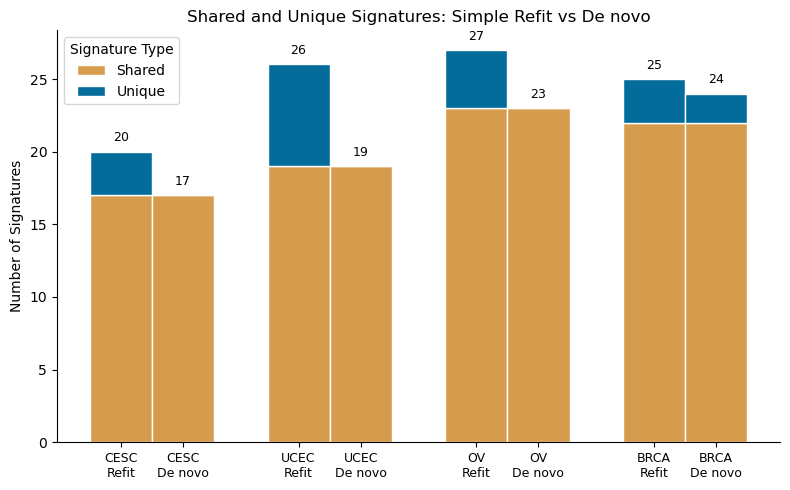

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Define colors
colors = {"Shared": "#D69C4E",  # Lighter gold
          "Unique": "#046C9A"}  # Darker purple

# Keep only CESC, UCEC, OV, BRCA (uppercase keys)
keep_groups = {
    "cesc": "CESC",
    "ucec": "UCEC",
    "ov": "OV",
    "brca": "BRCA"
}

# Prepare data
records = []

for key, tcga in keep_groups.items():
    simple = set(combined_simple_sigs[key])
    denovo = set(combined_denovo_sigs[key])
    shared = simple & denovo
    unique_simple = simple - denovo
    unique_denovo = denovo - simple

    records.append({"Group": tcga, "Source": "Simple Refit", "Shared": len(shared), "Unique": len(unique_simple)})
    records.append({"Group": tcga, "Source": "De novo", "Shared": len(shared), "Unique": len(unique_denovo)})

df = pd.DataFrame(records)

# Plot setup
fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
spacing = 0.3
groups = df["Group"].unique()
x = []

for i in range(len(groups)):
    x.append(i * (2 * bar_width + spacing))

# Plot bars
for i, group in enumerate(groups):
    simple = df[(df["Group"] == group) & (df["Source"] == "Simple Refit")]
    denovo = df[(df["Group"] == group) & (df["Source"] == "De novo")]

    # Values
    s_shared = simple["Shared"].values[0]
    s_unique = simple["Unique"].values[0]
    d_shared = denovo["Shared"].values[0]
    d_unique = denovo["Unique"].values[0]

    # Simple Refit bar
    ax.bar(x[i], s_shared, width=bar_width, color=colors["Shared"], edgecolor='white', linewidth=1)
    ax.bar(x[i], s_unique, bottom=s_shared, width=bar_width, color=colors["Unique"], edgecolor='white', linewidth=1)
    ax.text(x[i], s_shared + s_unique + 0.5, str(s_shared + s_unique), ha="center", va="bottom", fontsize=9)

    # De novo bar
    ax.bar(x[i] + bar_width, d_shared, width=bar_width, color=colors["Shared"], edgecolor='white', linewidth=1)
    ax.bar(x[i] + bar_width, d_unique, bottom=d_shared, width=bar_width, color=colors["Unique"], edgecolor='white', linewidth=1)
    ax.text(x[i] + bar_width, d_shared + d_unique + 0.5, str(d_shared + d_unique), ha="center", va="bottom", fontsize=9)


# X-tick positions: one per bar
xtick_positions = []
xtick_labels = []

for i, group in enumerate(groups):
    xtick_positions.append(x[i])  # Simple Refit bar
    xtick_labels.append(f"{group}\nRefit")
    
    xtick_positions.append(x[i] + bar_width)  # De novo bar
    xtick_labels.append(f"{group}\nDe novo")

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, fontsize=9, rotation=0, ha="center")

# Aesthetics
ax.set_ylabel("Number of Signatures")
ax.set_title("Shared and Unique Signatures: Simple Refit vs De novo")
ax.legend(["Shared", "Unique"], title="Signature Type")
ax.spines[['top', 'right']].set_visible(False)
ax.grid(False)
ax.set_ylim(0, None)

# # Add bar labels: "Simple Refit" and "De novo"
# for i in range(len(groups)):
#     ax.text(x[i], -1, "Simple Refit", ha="center", va="top", fontsize=8)
#     ax.text(x[i] + bar_width, -1, "De novo", ha="center", va="top", fontsize=8)

# # Add group labels beneath x-axis
# for i, group in enumerate(groups):
#     ax.text(x[i] + bar_width / 2, -2.5, group, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()

# Comments 

1. Matching *de novo* signatures to the catalog can be performed with `musical.refit.match()` in a similar way as described above, except that in matching, `X` will be the matrix of signatures to be matched. 

2. The `model` variable above is a `SparseNNLS` object. It provides many other attributes that are convenient. For example, `model.X_reconstructed` is the reconstructed mutation count matrix. `model.cos_similarities` is the cosine similarities between original data and the reconstructed spectra.  

3. Associated signatures (e.g., APOBEC signatures SBS2 and SBS13) can be forced to co-occur using the option `connected_sigs=True` (by default it is set to `False`). 